# Tennis

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from  collections  import deque
from itertools import count
import random
import torch
from ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

#env = UnityEnvironment(file_name="Tennis.app")
env = UnityEnvironment(file_name="C:/Users/hchan/Downloads/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Parameter setup

The following is where I setup or tune my hyperparameters

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 5e-4         # learning rate of the actor
LR_CRITIC = 5e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

### 4. Implementation of training and testing section

The follow is my implementation of training and testing codes

In [9]:
def ddpg(agent1, agent2, train=True):
    
    n_episodes = 4000 if train else 1
    
    scores1 = []
    scores2 = []
    mean_scores = []
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        score1 = 0
        score2 = 0
        while True:
            state1 = np.concatenate([state[0], [1]]).reshape((1,state.shape[1]+1))
            state2 = np.concatenate([state[1], [-1]]).reshape((1,state.shape[1]+1))
            action1 = agent1.act(state1)
            action2 = agent2.act(state2)
            env_info = env.step([action1, action2])[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            if train:
                next_state1 = np.concatenate([next_state[0], [1]])
                next_state2 = np.concatenate([next_state[1], [-1]])
                agent1.step(state1, action1, np.mean(reward), next_state1, done[0])
                agent2.step(state2, action2, np.mean(reward), next_state2, done[1])
                
            state = next_state
            score1 += reward[0]
            score2 += reward[1]
            if np.all(done):
                break

        scores1.append(score1)
        scores2.append(score2)
        mean_scores.append(np.mean([score1, score2]))
        mean1 = np.mean(scores1[-100:])
        mean2 = np.mean(scores2[-100:])
        mean_score = np.mean(mean_scores[-100:])

        print('\rEpisode {}\tAverage Score for Agent1:{:.2f}\tAverage Score for Agent2:{:.2f}\tAverage Score Both Agents:{:.2f}'.format(
            i_episode, mean1, mean2, mean_score), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score for Agent1:{:.2f}\tAverage Score for Agent2:{:.2f}\tAverage Score Both Agents:{:.2f}'.format(
            i_episode, mean1, mean2, mean_score))
            if train:
                agent1.save_progress()
        if mean_score>1 and train:
            agent1.save_progress()
            break

    return mean_scores

In [7]:
agent1 = Agent(state_size=state_size+1, action_size=action_size, random_seed=5, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, device=DEVICE)
agent2 = Agent(state_size=state_size+1, action_size=action_size, random_seed=5, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, device=DEVICE)

agent1.share_learning(agent2)

Episode 100	Average Score for Agent1:-0.00	Average Score for Agent2:-0.01	Average Score Both Agents:-0.00
Episode 200	Average Score for Agent1:-0.00	Average Score for Agent2:-0.00	Average Score Both Agents:-0.00
Episode 300	Average Score for Agent1:-0.00	Average Score for Agent2:-0.00	Average Score Both Agents:-0.00
Episode 400	Average Score for Agent1:-0.00	Average Score for Agent2:0.00	Average Score Both Agents:0.0000
Episode 500	Average Score for Agent1:0.01	Average Score for Agent2:0.01	Average Score Both Agents:0.010
Episode 600	Average Score for Agent1:0.04	Average Score for Agent2:0.04	Average Score Both Agents:0.04
Episode 700	Average Score for Agent1:0.11	Average Score for Agent2:0.13	Average Score Both Agents:0.12
Episode 800	Average Score for Agent1:0.43	Average Score for Agent2:0.46	Average Score Both Agents:0.45
Episode 828	Average Score for Agent1:1.00	Average Score for Agent2:1.02	Average Score Both Agents:1.01

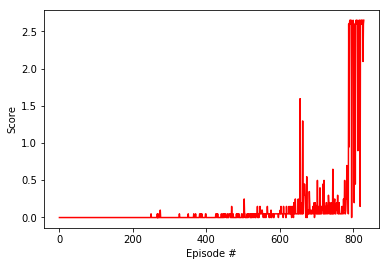

In [8]:
scores = ddpg(agent1, agent2)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, 'r-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
agent1 = Agent(state_size=state_size+1, action_size=action_size, random_seed=5, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, device=DEVICE, load_progress=True)
agent2 = Agent(state_size=state_size+1, action_size=action_size, random_seed=5, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, device=DEVICE, load_progress=True)

#agent1.share_learning(agent2)
ddpg(agent1, agent2, train=False)

Episode 1	Average Score for Agent1:1.80	Average Score for Agent2:1.69	Average Score Both Agents:1.75

[1.7450000261887908]

In [12]:
env.close()